# Business Questions. 
_We want answers!_ 

**The company's business areas have some doubts and challenges such as:**


- Can we give the same benefits to all shopkeepers (sellers)? Or is there one that deserves to be highlighted?


- Is there a difference in the amount of freight charged in different regions, cities? Or can we apply the shipping subsidy rules to any location?


- Is our product catalog comprehensive? Or does it focus on specific categories?


- Do we always sell the same products? Or are there seasonalities?



**Dashboard that analyzes the company's latest sales data that can be shared with Regional leads and their respective analysts:**

- Total Sales
- Sales per Region
- Top 5 selling categories for each Region

_delivered orders only_

In [4]:
import psycopg2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import date

import dotenv
import os

dotenv.load_dotenv(dotenv.find_dotenv(os.path.expanduser("-")))

True

In [5]:
conn = psycopg2.connect(host="localhost", user="postgres", password=os.getenv("POSTGRES_PASSWORD"), database='postgres')
cursor = conn.cursor()

In [73]:
def bd_execute(query):
    cursor.execute(query)
    return [table for table in cursor.fetchall()]

def to_pandas(query_result, columns):
    return pd.DataFrame(query_result, columns=columns)

def write_query(file_name, query):
    with open(f'{file_name}.sql', 'w') as file:
        file.write(query)

def read_query(path):      
    with open(f'{path}', 'r') as file:
        return file.read()

In [53]:
intial_date = date(2018, 1, 1)
final_date = date(2019, 1, 1)
sales_per_month_query = f'''
SELECT date_trunc('month', order_purchase_timestamp), SUM(price+freight_value)
FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
WHERE order_status='delivered' and
      order_purchase_timestamp BETWEEN date('{intial_date}') AND date('{final_date}')
GROUP BY date_trunc('month', order_purchase_timestamp)
'''
annual_sales = to_pandas(bd_execute(sales_per_month_query), ['month','total_sales']).sort_values('month')

In [82]:
write_query("../sql_queries/sales_per_month_query", sales_per_month_query)
print(read_query("../sql_queries/sales_per_month_query.sql"))


SELECT date_trunc('month', order_purchase_timestamp), SUM(price+freight_value)
FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
WHERE order_status='delivered' and
      order_purchase_timestamp BETWEEN date('2018-01-01') AND date('2019-01-01')
GROUP BY date_trunc('month', order_purchase_timestamp)



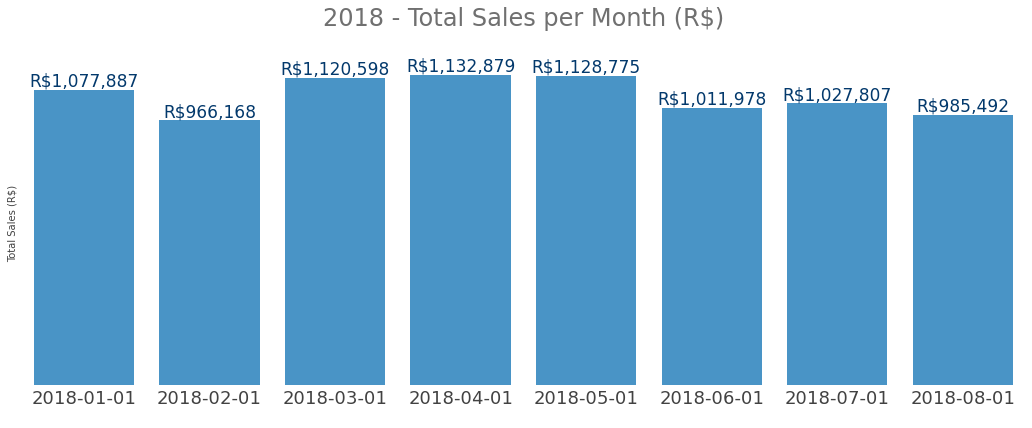

In [60]:
x = list(range(len(annual_sales['month'])))
sales = annual_sales['total_sales'].values
plt.figure(figsize=(18,6))
sns.barplot(data=annual_sales, x=annual_sales['month'].dt.date, y='total_sales', color='#3498db');

plt.box(False)
plt.title(f"2018 - Total Sales per Month (R$)\n", fontsize=24, color='#707070')
plt.tick_params(axis='both', which='both', length=0)
plt.xlabel(" ", color='#424242')
plt.ylabel("Total Sales (R$)", color='#424242')
plt.xticks(color="#424242", size=18)
plt.yticks([],[])

for sale_value in range(len(sales)):
    plt.annotate("R${:,.0f}".format(sales[sale_value]), xy=(x[sale_value],sales[sale_value]),
                 ha='center', va='bottom', size=17, color='#03396c')
plt.show()